In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import requests
import os

<h4>Old Preprocessing procedure, now at RPPPpipeline.py</h4>

In [2]:
al = pd.read_csv("PPR-ALL.csv", encoding='ISO-8859-1', low_memory=False)

In [3]:
al['Full'] = al['Address']+", "+al['County']
al['Date'] = pd.to_datetime(al['Date of Sale (dd/mm/yyyy)'], format='%d/%m/%Y')
al['Full Market Price'] = al['Not Full Market Price'].replace({'Yes':0, 'No':1})
al['VAT exclusive'] = al['VAT Exclusive'].replace({'Yes':1, 'No':0})

In [4]:
al['Price'] = (al.iloc[:,4]
                .str.replace(',', '')
                .str.slice(1)
                .astype('float32'))

In [5]:
#remove all the unnecessary columns
al = (al
   .drop('Price ()', axis=1)
   .drop('Eircode', axis=1)
   .drop('Property Size Description', axis=1)
   .drop('Not Full Market Price' ,axis=1)
   .drop('VAT Exclusive',axis=1)
   .drop('Date of Sale (dd/mm/yyyy)',axis=1)
   .drop('Description of Property',axis=1)

)

In [6]:
al.head()

,Address,County,Full,Date,Full Market Price,VAT exclusive,Price
0,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,"5 Braemor Drive, Churchtown, Co.Dublin, Dublin",2010-01-01,1,0,343000.0
1,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,"134 Ashewood Walk, Summerhill Lane, Portlaoise...",2010-01-03,1,1,185000.0
2,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,"1 Meadow Avenue, Dundrum, Dublin 14, Dublin",2010-01-04,1,0,438500.0
3,"1 The Haven, Mornington",Meath,"1 The Haven, Mornington, Meath",2010-01-04,1,0,400000.0
4,"11 Melville Heights, Kilkenny",Kilkenny,"11 Melville Heights, Kilkenny, Kilkenny",2010-01-04,1,0,160000.0


<h4>Getting coordinates</h4>

In [7]:
start = pd.to_datetime('2023-01-01')  
end = pd.to_datetime('2023-06-30')
f23 = al[(al['Date'] >= start) & (al['Date'] <= end)]
b23 = f23.sort_values('Date')

In [7]:
b23.head()
len(b23)

26600

In [32]:
start = pd.to_datetime('2022-01-01')  
end = pd.to_datetime('2022-12-31')
f22 = al[(al['Date'] >= start) & (al['Date'] <= end)]
b22 = f22.sort_values('Date')

In [33]:
b22.head()
len(b22)

62440

In [10]:
start = pd.to_datetime('2022-12-01')  
end = pd.to_datetime('2022-12-31')
f22 = al[(al['Date'] >= start) & (al['Date'] <= end)]
b22 = f22.sort_values('Date')

In [11]:
b22.head()
len(b22)

6772

In [10]:
jan = b23[b23['Date'] <= pd.to_datetime('2023-01-31')]
jan = jan.sort_values('Date')

In [12]:
print(len(jan))

3615


In [38]:
feb = b23[(b23['Date'] >= pd.to_datetime('2023-02-01')) & (b23['Date'] <= pd.to_datetime('2023-02-28'))]
feb = feb.sort_values('Date')

In [39]:
print(len(feb))

4281


<h4>Geocoding</h4>

In [12]:
g = os.environ.get("googol")

Improve iterations:  
If geolocation is out of bounds, try with a county?  
If none, try with an eircode?

In [13]:
def get_coordinates(address):
    url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={g}'
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        lat = data['results'][0]['geometry']['location']['lat']
        lng = data['results'][0]['geometry']['location']['lng']
        return lat, lng
    else:
        return None

# Create new columns for latitude and longitude
#df['latitude'], df['longitude'] = zip(*df['address'].apply(get_coordinates))

<h4>Iteration</h4>

In [15]:
#itr = jan['Full'].to_list()
#itr = feb['Full'].to_list()

In [14]:
#itr = b23['Full'].to_list()
itr = b22['Full'].to_list()

In [15]:
print(len(itr))

6772


In [16]:
latit = []
longt = []

In [17]:
from IPython.display import clear_output

In [18]:
for i in itr:
    imp = get_coordinates(i)
    if imp is None:
        print(f"Failed to get coordinates for {i}")
        latit.append(None)
        longt.append(None)
        time.sleep(0.5)
    else:
        latit.append(imp[0])
        longt.append(imp[1])
        clear_output(wait=True)
        print(f"{i}, {imp[0]}, {imp[1]}")
        time.sleep(0.5)

APT 22 -  PEARSE COURT, PEARSE STREET, ATHLONE, Westmeath, 53.4221488, -7.944692499999999


In [26]:
print(len(latit))
print(len(longt))
print(latit.count(None))
print(longt.count(None))
print(len(b22))

26600
26600
81
80
26600


In [27]:
for i in range(len(latit)):
    if latit[i] == None:
        latit[i] = None
    elif latit[i] < 45:
        latit[i] = None

In [37]:
for i in range(len(longt)):
    if longt[i] == None:
        longt[i] = None
    elif longt[i] < -20: #| longt[i] > -5.9:
        longt[i] = None

In [29]:
print(latit.count(None))
print(longt.count(None))

81
26586


In [23]:
b23['Latitude'] = latit
b23['Longitude'] = longt

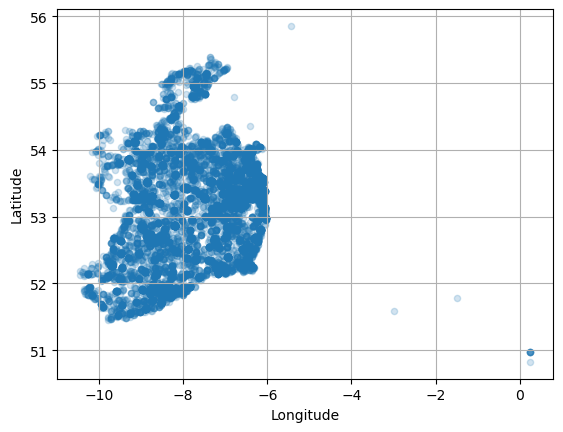

In [24]:
b23.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, alpha=0.2)
plt.show()

In [ ]:
b22['Latitude'] = latit
b22['Longitude'] = longt

In [ ]:
b22.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, alpha=0.2)
plt.show()

<h4>TODO: Normalise data for a good graph</h4>

<h4>Do some Knn on the VAT thing or whatever</h4>

In [25]:
b23.to_csv("2023.csv", index=False)

In [ ]:
b22.to_csv("2022.csv", index=False)